In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


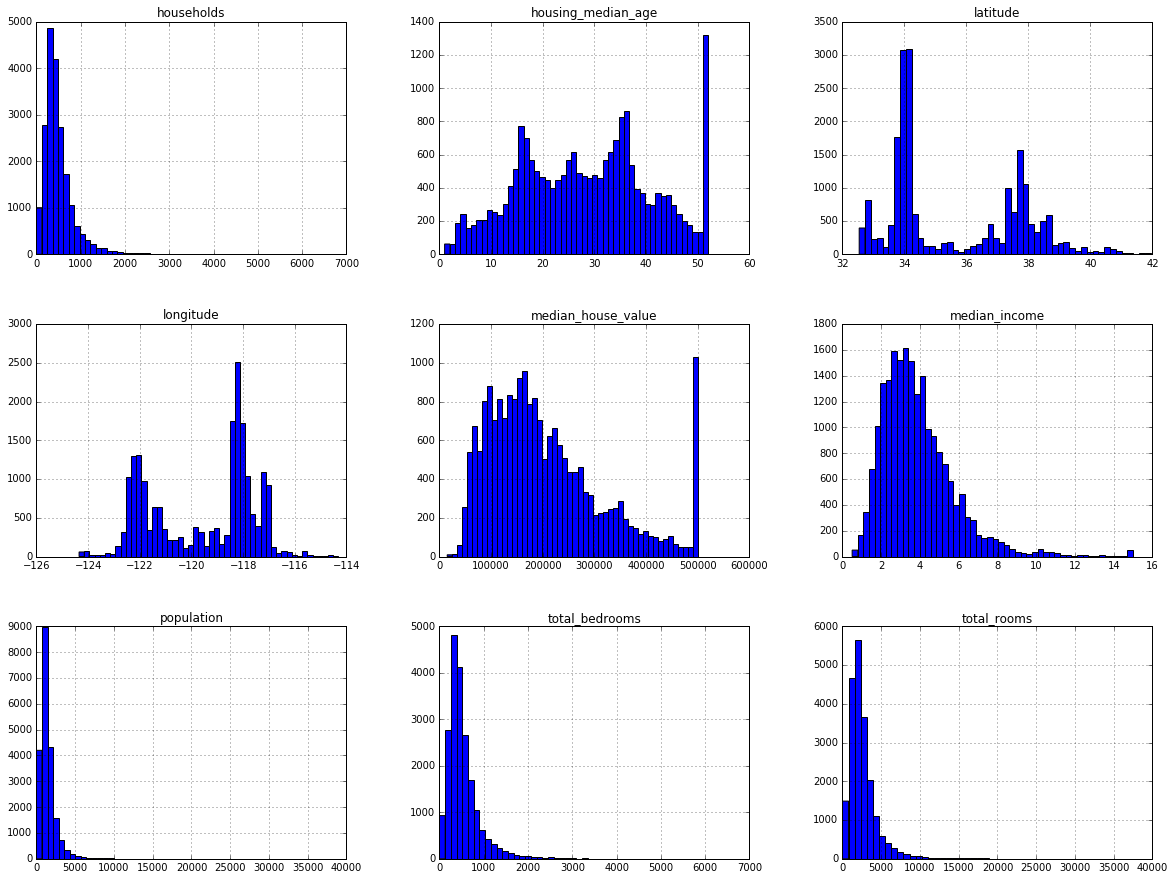

In [7]:
%matplotlib inline
# only in a Jupyter notebook
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Need to set aside a proper test set before we move forward

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    """This first function is not ideal as it is not deterministic
    Initialising the random number generator would not be enough
    """
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [10]:
# This next split function uses an hash 
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
# adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
# this would only work if new data is added at the end of the dataset

In [12]:
# this is the most deterministic we can do
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_with_id, test_size=0.2, random_state=42)

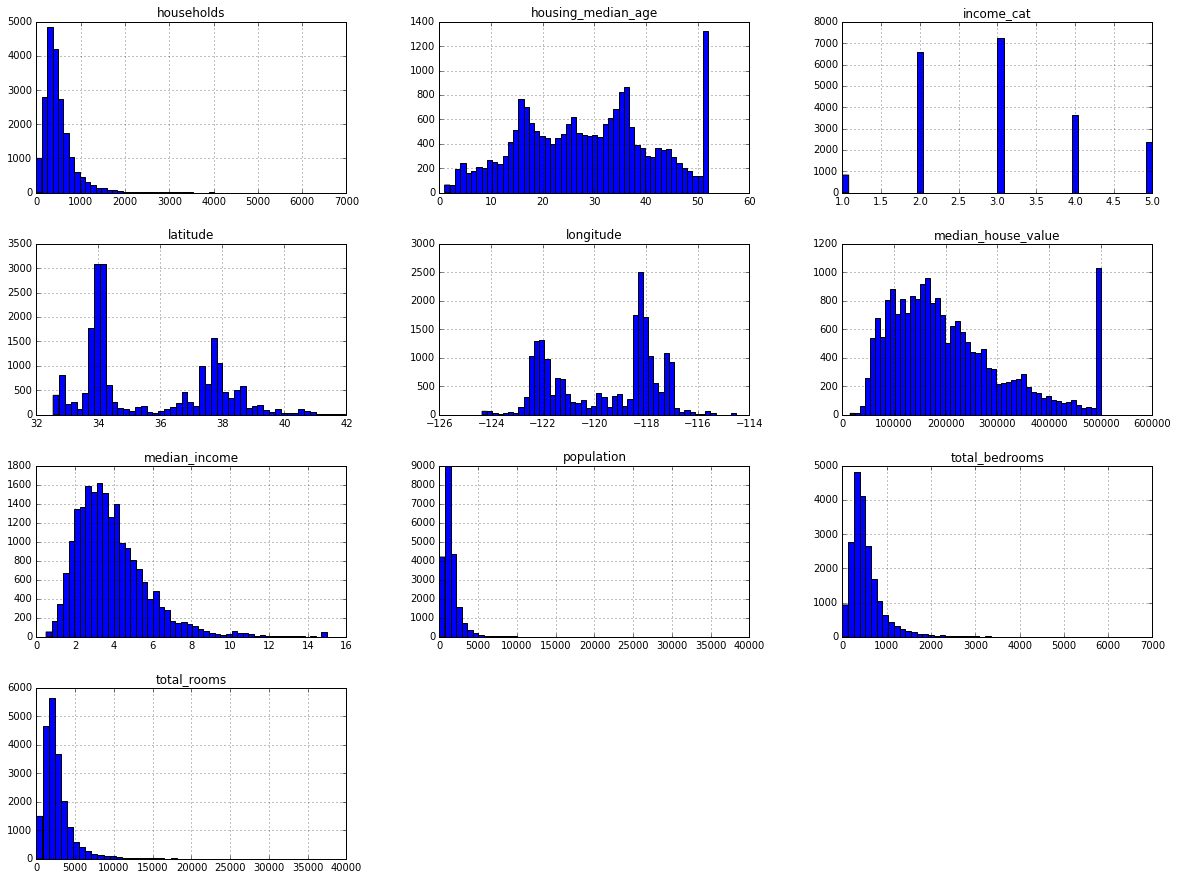

In [14]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [16]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [18]:
# now we can drop the income cat column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [19]:
#override the housing variable
housing = strat_train_set.copy()

# Data visualisation

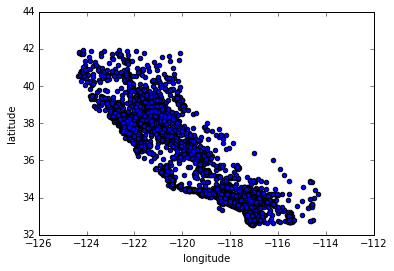

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")

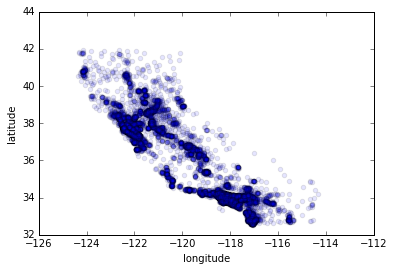

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

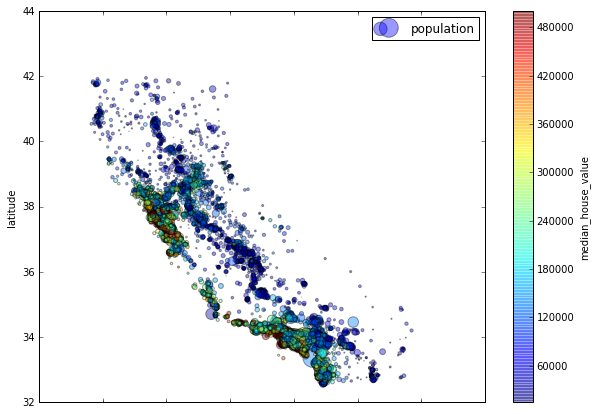

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

# Looking for correlation

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cdf7940f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2cdfb83f98>]], dtype=object)

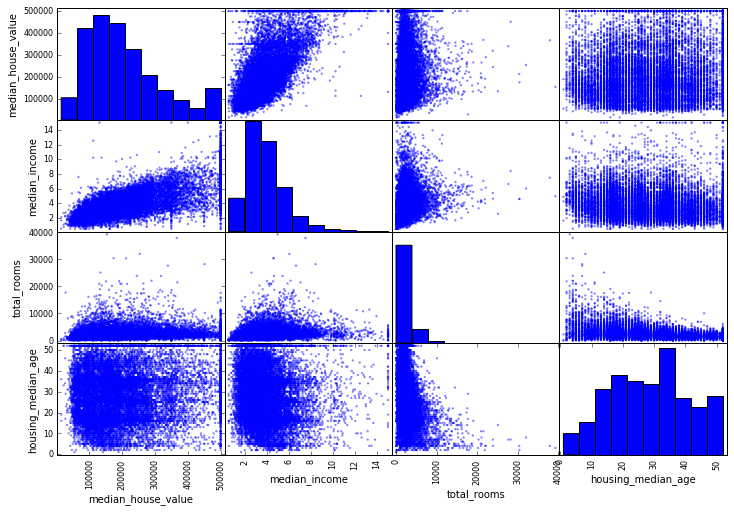

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

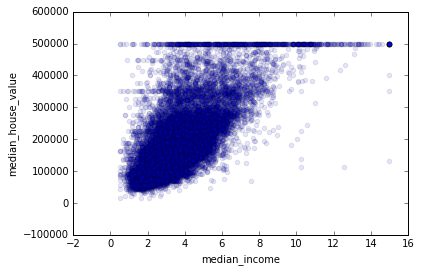

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

# Features ingineering

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [28]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare data

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [30]:
housing.dropna(subset=["total_bedrooms"])
# option 1
housing.drop("total_bedrooms", axis=1)
# option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [31]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1) # remove the ocean proximity to avoid fitting error
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [32]:
X = imputer.transform(housing_num)

In [33]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [34]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.0 MB


In [35]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(housing["ocean_proximity"])
housing_cat_encoded = encoder.fit_transform(housing["ocean_proximity"])
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [36]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [37]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [38]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [39]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [40]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='<U10')

In [41]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ..., 
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

# Pipelines

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [44]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [46]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

In [47]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [48]:
housing_prepared.shape

(16512, 16)

In [49]:
housing.shape

(16512, 9)

In [50]:
type(housing_prepared)

numpy.ndarray

# model trainings

In [51]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [52]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [53]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489219

In [54]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

0 rmse is likely to be linked to an overfitting. Cannot use the test case now so we use cross validation

In [55]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [56]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [ 70268.09552927  67253.94873     72086.85627775  68930.44984156
  71985.24069263  76573.23433419  71089.92121791  69656.41589278
  75724.45473307  69871.10156798]
Mean: 71343.9718817
Standard deviation: 2762.05612875


In [57]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
    scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66755.35819855  66966.14573098  70347.95244419  74769.18698807
  68031.13388938  71229.17716103  64959.86064183  68270.70198961
  71552.91566558  67665.10082067]
Mean: 69054.753353
Standard deviation: 2744.21870838


In [58]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22381.149926900547

In [59]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52329.77738536  51055.95172284  53696.06891594  54681.34590104
  52899.00655676  55372.63064702  51989.73045838  50453.30947815
  55715.3637158   52528.96690078]
Mean: 53072.2151682
Standard deviation: 1680.14085837


## Neural network

In [68]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=(100,), solver='lbfgs') #activation='identity'
mlp_reg.fit(housing_prepared, housing_labels)
housing_predictions = mlp_reg.predict(housing_prepared)
mlp_reg_mse = mean_squared_error(housing_labels, housing_predictions)
mlp_reg_rmse = np.sqrt(mlp_reg_mse)
mlp_reg_rmse

53319.66839736871

In [69]:
mlp_scores = cross_val_score(mlp_reg, housing_prepared, housing_labels, 
                                scoring="neg_mean_squared_error", cv=10)
mlp_rmse_scores = np.sqrt(-mlp_scores)
display_scores(mlp_rmse_scores)

Scores: [ 56343.40987943  55045.63971275  57595.24449814  57328.07790285
  55530.5738541   57928.7917484   54098.12949563  52987.0267729
  57526.05286677  54553.57659677]
Mean: 55893.6523328
Standard deviation: 1621.13932702


## SVM machines

In [72]:
from sklearn.svm import NuSVR

svm_reg = NuSVR(kernel='sigmoid')
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_reg_mse = mean_squared_error(housing_labels, housing_predictions)
svm_reg_rmse = np.sqrt(svm_reg_mse)
svm_reg_rmse

116287.63318322686

# Model fine tuning

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [2, 4, 6, 8], 'n_estimators': [3, 10, 30]}, {'bootstrap': [False], 'max_features': [2, 3, 4], 'n_estimators': [3, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [75]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64567.4740124 {'max_features': 2, 'n_estimators': 3}
56209.5036771 {'max_features': 2, 'n_estimators': 10}
53049.6474611 {'max_features': 2, 'n_estimators': 30}
60313.98548 {'max_features': 4, 'n_estimators': 3}
53083.0607785 {'max_features': 4, 'n_estimators': 10}
50613.3999823 {'max_features': 4, 'n_estimators': 30}
60331.1788544 {'max_features': 6, 'n_estimators': 3}
52183.1208318 {'max_features': 6, 'n_estimators': 10}
49891.6464229 {'max_features': 6, 'n_estimators': 30}
58491.2780566 {'max_features': 8, 'n_estimators': 3}
51907.4188853 {'max_features': 8, 'n_estimators': 10}
50365.3490948 {'max_features': 8, 'n_estimators': 30}
63220.4798356 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55083.2209721 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60144.6279518 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52461.8403702 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58690.3883222 {'bootstrap': False, 'max_features': 4, 'n_estimat

## with the neural network

In [77]:
param_grid = [
    {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(50,), (100,), (200,), (300,)]},
]
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,), solver='lbfgs')

grid_search = GridSearchCV(mlp_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(50,), (100,), (200,), (300,)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)